In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import stormeunice as eun
import multiprocessing
import glob
import dask
import netCDF4



sys.path.append('/home/e/ermis/moarpalettes')
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

In [2]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(import_medr_tracks_TE, glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])


ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min))


NameError: name 'import_medr_tracks_TE' is not defined

In [11]:
# Import track data
P1 = multiprocessing.Pool(40)
ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))
P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

# add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=preproc_to_stormframeTrue)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

dudley_track = era_track.query('track_id==4')
##ofc, I didn't write another filter to find where dudley is. Since there are only a choice or two, I just checked each of them manually.


In [4]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
dudley_filter = dudley_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - dudley_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-dudley_filter.lon)**2+(ifs_tracks_filter.lat-dudley_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_dudley_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

# For members with more than one Eunice-like track: keep the ones with the longest track? 
multi_track_members = ifs_dudley_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_dudley_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=dudley_track))
    num_reject = track_dists.idxmax()
    ifs_dudley_list_idx = ifs_dudley_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_dudley_list = ifs_dudley_list.drop(ifs_dudley_list_idx)


In [4]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_dudley_track = ERA5_tracks.query('uid=="202202084"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_dudley_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_dudley_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_dudley_track.lat*4).round()/4)

ERA5_dudley_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
early_date = pd.Timestamp(2022,2,9, 0)
late_date = pd.Timestamp(2022,2,16, 18)

# Filter uid
dudley_ids = [] # fill with those ids that could be Eunice
for id_ in pd.unique(ERA5_tracks.uid): 
    # print(id_)
    data_for_id = ERA5_tracks[ERA5_tracks.uid == id_]
    # print('Genesis data: ', data_for_id.date[0], data_for_id.long[0], data_for_id.lat[0])
    min_pres = min(data_for_id.p_cent) < 98000  # in Pa not hPa 
    gen_lat = (data_for_id.lat[0] > 30) & (data_for_id.lat[0] < 75)
    gen_long = (data_for_id.long [0] > -90) & (data_for_id.long[0] < 0)
    gen_time = ((data_for_id.date[0] >=  early_date) & (data_for_id.date[0] <= late_date))

    # print(min_pres, gen_lat, gen_long, gen_time)
    
    if min_pres & gen_lat & gen_long & gen_time:
        dudley_ids.append(id_)

dudley_ids

['202202040', '202202069', '202202084']

dudley should be one of the ['202202040', '202202051', '202202053'] I believe
But actually '202202084', 5 figures later than Eunice, quite surprising to be very fair

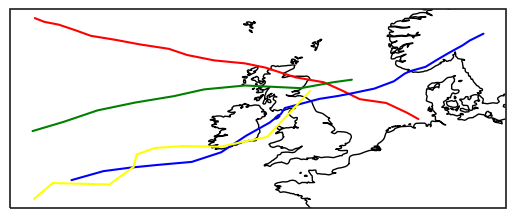

In [8]:


fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
projection = ccrs.PlateCarree()

sns.lineplot(data=ERA5_tracks[ERA5_tracks.uid == '202202040'],x='long',y='lat', color = 'red',legend=True)
sns.lineplot(data=ERA5_tracks[ERA5_tracks.uid == '202202051'],x='long',y='lat', color='blue', legend=True)
sns.lineplot(data=ERA5_tracks[ERA5_tracks.uid == '202202084'][:10],x='long',y='lat', color='green',  legend=True)#Great, this is my lovely little monsterous distressing Dudley
sns.lineplot(data=ERA5_tracks[ERA5_tracks.uid == '202202079'][:10],x='long',y='lat', color='yellow',  legend=True)#And this is Eunice. How sweet. Eunice is spotted before Dudley for some unknown reason.
ax.coastlines()


Now it seems like dudley is 202202040 ? Nope actually 202202051
or not 

In [6]:
print(ERA5_tracks[ERA5_tracks.uid == '202202084'])

            Dp         DpDt        DsqP    Dx    Dy  Ege  Ely  Emg  Erg  Esp  \
0          NaN          NaN   91.530110   NaN   NaN    3    0    0    0    0   
1  -247.302391 -2123.371018   67.995079   8.0   0.0    0    0    0    0    0   
2  -338.165059 -2867.625122   70.657698   9.0   1.0    0    0    0    0    0   
3  -192.249151 -1617.157706   79.021386   9.0   0.0    0    0    2    0    0   
4  -107.640106  -899.569545   84.648667   9.0   0.0    0    0    0    0    2   
5  -294.939683 -2448.484848  103.134579   7.0   1.0    0    0    0    0    0   
6     0.850448     7.033385  115.799882   9.0   0.0    0    0    0    0    0   
7   227.180570  1883.690012   71.125056  12.0  -2.0    0    0    2    0    0   
8   -37.045037  -305.415214   63.951633   7.0   2.0    0    0    0    0    0   
9   -80.492252  -661.995460   66.190422   4.0   1.0    0    0    0    0    0   
10 -223.096119 -1836.320683   62.764618   6.0   0.0    0    0    0    0    0   
11 -195.611583 -1606.234303   47.820360 

<Axes: xlabel='long', ylabel='lat'>

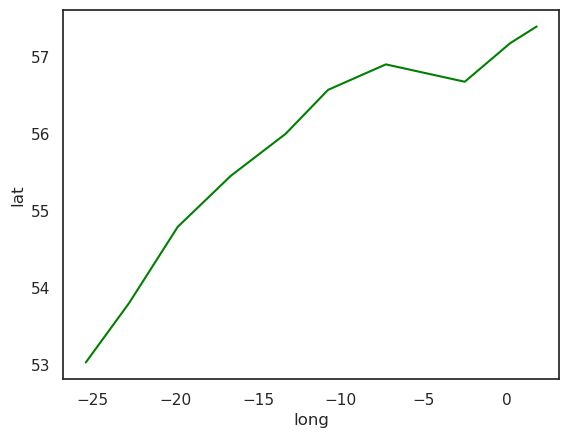

In [ ]:
#ERA5_tracks[ERA5_tracks.uid == '202202079']
#THIS IS FOR EUNICE

['/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc',
 '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc']

In [ ]:
[x for x in glob.glob() if not '02-16' in x]

In [9]:
# capture 
# Ignore outputs

# Import field data, Lagrangian fram
curr_storms = xr.open_mfdataset([x for x in glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc') if not '02-16' in x],
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_dudley_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset([x for x in glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc') if not '02-16' in x],
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_dudley_list),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset([x for x in glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc') if not '02-16' in x],
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_dudley_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/stormeunice/lagrangian.py:153: FutureWarning: Following pandas, the `base` parameter to resample will be deprecated in a future version of xarray.  Switch to using `origin` or `offset` instead.
  mxtpr_field_out = mem_fields.mxtpr.sel(time=slice(time_start, time_end)).resample(time='{}h'.format(resample_freq), label='right', closed='right', base=0).max()
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/stormeunice/lagrangian.py:153: FutureWarning: Following pandas, the `base` parameter to resample will be deprecated in a future version of xarray.  Switch to using `origin` or `offset` instead.
  mxtpr_field_out = mem_fields.mxtpr.sel(time=slice(time_start, time_end)).resample(time='{}h'.format(resample_freq), label='right', closed='right', base=0).max()
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/stormeunice/lagrangian.py:179: FutureWarning: 

In [10]:
incr_storms

<xarray.Dataset>
Dimensions:       (storm_lon: 81, storm_lat: 81, timestep: 55, number: 40,
                   experiment: 1, inidate: 2)
Coordinates:
  * storm_lon     (storm_lon) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * storm_lat     (storm_lat) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * timestep      (timestep) float64 -3.75 -3.5 -3.25 -3.0 ... 3.875 4.0 4.25
  * number        (number) int32 2 3 4 5 6 7 9 10 13 ... 41 43 44 45 46 47 48 50
  * experiment    (experiment) object 'incr'
  * inidate       (inidate) datetime64[ns] 2022-02-14 2022-02-10
Data variables: (12/14)
    sst           (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 81, 81), meta=np.ndarray>
    u10           (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 81, 81), meta=np.ndarray>
    v10           (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 81, 81), meta=np.ndarray>
    msl           (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 81, 81), meta=np.ndarray>
    u100          (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 81, 81), meta=np.ndarray>
    v100          (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 81, 81), meta=np.ndarray>
    ...            ...
    ws10          (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 81, 81), meta=np.ndarray>
    ws100         (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 81, 81), meta=np.ndarray>
    mxtpr         (inidate, experiment, number, timestep, storm_lat, storm_lon) float32 dask.array<chunksize=(1, 1, 1, 1, 81, 81), meta=np.ndarray>
    centroid_lon  (inidate, experiment, number, timestep) float64 nan ... nan
    centroid_lat  (inidate, experiment, number, timestep) float64 nan ... nan
    datetime      (inidate, experiment, number, timestep) datetime64[ns] NaT ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-12-09 04:01:11 GMT by grib_to_netcdf-2.26.0: grib_to_n...

AttributeError: 'str' object has no attribute 'copy'

/tmp/user/27783/ipykernel_2447688/2880799507.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('6 days lead')
/tmp/user/27783/ipykernel_2447688/2880799507.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('2 days lead')
/tmp/user/27783/ipykernel_2447688/2880799507.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('0 days lead')
/tmp/user/27783/ipykernel_2447688/2880799507.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27783/ipykernel_2447688/2880799507.py:8: DeprecationWarning: self.axes is deprecated si

Text(74.0, 0.5, 'lat from storm centre')

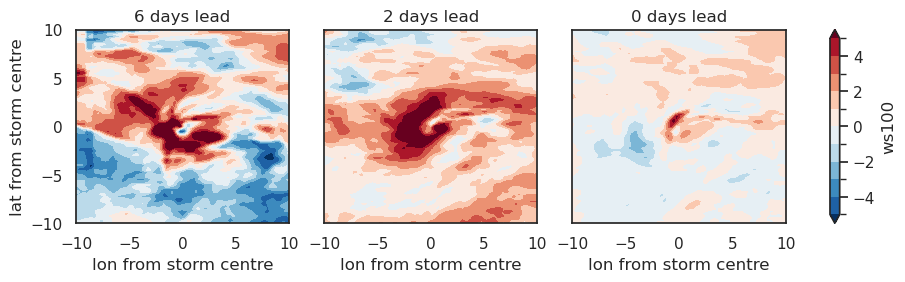

In [9]:
cplot = (incr_storms.ws100.sel(timestep=0).mean('number').squeeze() - pi_storms.ws100.sel(timestep=0).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

cplot.axes[0,0].set_title('6 days lead')
cplot.axes[0,1].set_title('2 days lead')
cplot.axes[0,2].set_title('0 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')